# Source Detection

In [1]:
import sys
sys.path.insert(0, '/home/lukas/i4ds/ska/Karabo-Pipeline')

In [2]:
from karabo.imaging import imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import SourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

import matplotlib.pyplot as plt
# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


## Simulation

/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/simulation/sky_model.py:434: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


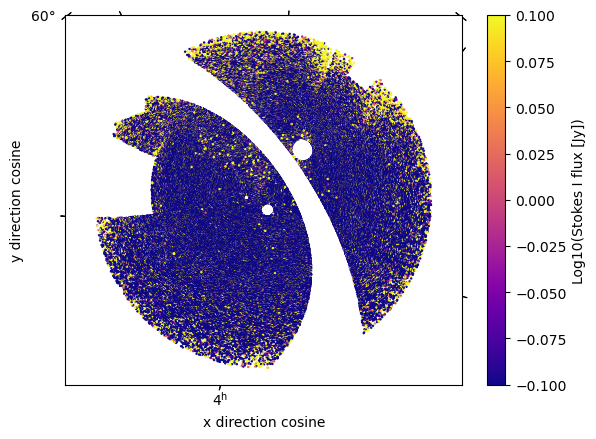

In [3]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky()
gleam_sky.plot_sky(phase_center)

Then we filter the sky model based on radius.

In [4]:
sky = gleam_sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

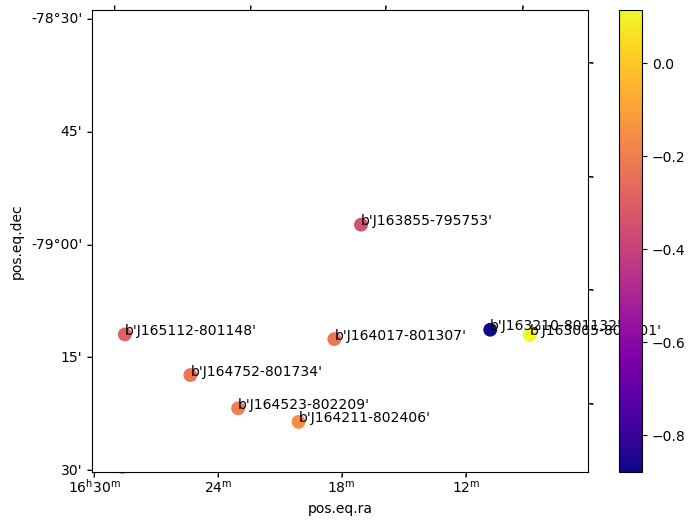

In [5]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    s=80,
    xlim=(-.55, .55),
    ylim=(-.55, .55),
    with_labels=True,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

In [ ]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [ ]:
observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=64,
    number_of_time_steps=24,
)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(askap_tel, sky, observation_settings)

### Dirty Images

We can create dirty images of visibilites and display them as shown below

In [9]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

In [ ]:
imager_askap = imager.Imager(
    visibility_askap,
    imaging_npixel = imaging_npixel,
    imaging_cellsize = imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title='Dirty image')

### Source Detection

In [7]:
detection_result_dirty = SourceDetectionResult.detect_sources_in_dirty_image(imager_askap)

In [10]:
ground_truth = imager.Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)
ground_truth

(array([ 983.7541719 ,  923.47622896,  875.76150634, 1214.68252179,
        1019.4823065 , 1175.05313524,  810.42477501, 1046.05954221]),
 array([ 843.99399139,  857.57544953,  890.71521423,  930.8138393 ,
         926.59679683,  935.95007904,  931.27137963, 1040.78864429]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

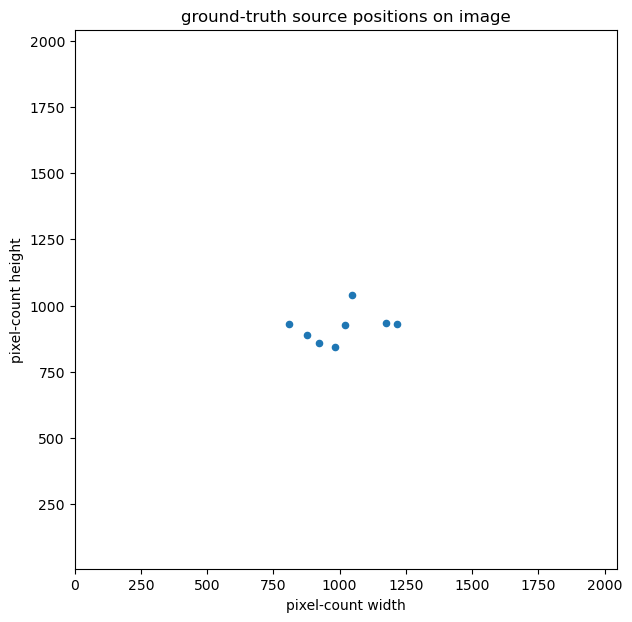

In [18]:
fig, ax = plt.subplots(
    figsize=(7,7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title('ground-truth source positions on image')
plt.xlim((0,imaging_npixel))
plt.ylim((0,imaging_npixel))
plt.xlabel('pixel-count width')
plt.ylabel('pixel-count height')
plt.show()

In [ ]:
# Create mapping plots
mapping_dirty = SourceDetectionEvaluation.evaluate_result_with_sky_in_pixel_space(detection_result_dirty, sky, 10)
mapping_dirty.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [ ]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm='mmclean',
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=.3,
    clean_threshold=.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output='integrated',
)

## Analysis via Source Detection

Source Detection on restored image.

In [ ]:
detection_result = SourceDetectionResult.detect_sources_in_image(restored)

In [ ]:
sky.project_sky_to_image(image=imager_askap, filter_outlier=True)

## Evaluation

In [ ]:
# Create mapping plots
mapping = SourceDetectionEvaluation.evaluate_result_with_sky_in_pixel_space(detection_result, sky, 10)
mapping.plot()

In [ ]:
# Confusion Matrix
mapping.get_confusion_matrix()

In [ ]:
mapping.plot_confusion_matrix()

In [ ]:
mapping_dirty.plot_confusion_matrix()

In [ ]:
# Plot error ra and dec
mapping.plot_error_ra_dec()

In [ ]:
# Plot error ra and dec
mapping_dirty.plot_error_ra_dec()

In [ ]:
# Plot error flux
mapping.plot_quiver_positions()

In [ ]:
# Plot error flux
mapping_dirty.plot_quiver_positions()

In [ ]:
# Plot error ra and dec
mapping.plot_flux_ratio_to_distance()

In [ ]:
# Plot error ra and dec
mapping.plot_flux_histogram()

In [ ]:
# Plot error ra and dec
mapping_dirty.plot_flux_histogram()

In [ ]:
# Plot error ra and dec
mapping.plot_flux_ratio_to_ra_dec()

In [ ]:
# Plot error ra and dec
mapping_dirty.plot_flux_ratio_to_ra_dec()